In [1]:
#importing packages
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#import geopandas as gpd #having some dificulty with geopandas, have tried a number of different versions,
#appears pyproj is the issue

Data imported from Github repo, alos available at the following source as provide by DrivenData on behalf of Taarifa (Tanzania Ministry of Water)

Data Source <https://www.drivendata.org/competitions/7/pump-it-up-data-mining-the-water-table/data/>

Data inlcudes a set of training data with labels and a set of test data for prediction and submission

In [2]:
values = pd.read_csv('Source_data/trainset_values.csv')

Taking a look at the data below gives us a feel for what has been provided

In [3]:
values.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,...,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,...,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,...,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,...,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,...,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe


In [4]:
values.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59400 entries, 0 to 59399
Data columns (total 40 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     59400 non-null  int64  
 1   amount_tsh             59400 non-null  float64
 2   date_recorded          59400 non-null  object 
 3   funder                 55765 non-null  object 
 4   gps_height             59400 non-null  int64  
 5   installer              55745 non-null  object 
 6   longitude              59400 non-null  float64
 7   latitude               59400 non-null  float64
 8   wpt_name               59400 non-null  object 
 9   num_private            59400 non-null  int64  
 10  basin                  59400 non-null  object 
 11  subvillage             59029 non-null  object 
 12  region                 59400 non-null  object 
 13  region_code            59400 non-null  int64  
 14  district_code          59400 non-null  int64  
 15  lg

We see that ther are some null values in columns 
['funder', 'installer', 'subvillage', 'public_meeting', 'scheme_management', 'scheme_name', 'permit']
that will need to be handled. It also appears that some columns provide overlapping information (extraction, management, payment, water quality and quantity, source and waterpoint). We will have to investiagte further if each column provides enough new information to keep. 

In [5]:
labels = pd.read_csv('Source_data/trainset_labels.csv')

Taking a look at the training labels below we see that there are 3 groups: functional, non functional and 

In [6]:
labels.head()

,id,status_group
0,69572,functional
1,8776,functional
2,34310,functional
3,67743,non functional
4,19728,functional


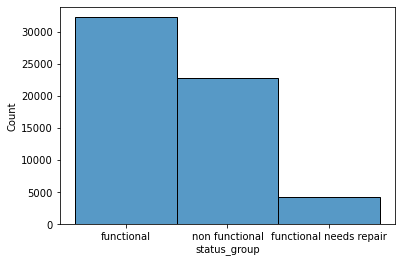

In [7]:
sns.histplot(data=labels, x='status_group')
plt.show()

In [8]:
values.columns

Index(['id', 'amount_tsh', 'date_recorded', 'funder', 'gps_height',
       'installer', 'longitude', 'latitude', 'wpt_name', 'num_private',
       'basin', 'subvillage', 'region', 'region_code', 'district_code', 'lga',
       'ward', 'population', 'public_meeting', 'recorded_by',
       'scheme_management', 'scheme_name', 'permit', 'construction_year',
       'extraction_type', 'extraction_type_group', 'extraction_type_class',
       'management', 'management_group', 'payment', 'payment_type',
       'water_quality', 'quality_group', 'quantity', 'quantity_group',
       'source', 'source_type', 'source_class', 'waterpoint_type',
       'waterpoint_type_group'],
      dtype='object')

- amount_tsh - Total static head (amount water available to waterpoint)
- date_recorded - The date the row was entered
- funder - Who funded the well
- gps_height - Altitude of the well
- installer - Organization that installed the well
- longitude - GPS coordinate
- latitude - GPS coordinate
- wpt_name - Name of the waterpoint if there is one
- num_private -
- basin - Geographic water basin
- subvillage - Geographic location
- region - Geographic location
- region_code - Geographic location (coded)
- district_code - Geographic location (coded)
- lga - Geographic location
- ward - Geographic location
- population - Population around the well
- public_meeting - True/False
- recorded_by - Group entering this row of data
- scheme_management - Who operates the waterpoint
- scheme_name - Who operates the waterpoint
- permit - If the waterpoint is permitted
- construction_year - Year the waterpoint was constructed
- extraction_type - The kind of extraction the waterpoint uses
- extraction_type_group - The kind of extraction the waterpoint uses
- extraction_type_class - The kind of extraction the waterpoint uses
- management - How the waterpoint is managed
- management_group - How the waterpoint is managed
- payment - What the water costs
- payment_type - What the water costs
- water_quality - The quality of the water
- quality_group - The quality of the water
- quantity - The quantity of water
- quantity_group - The quantity of water
- source - The source of the water
- source_type - The source of the water
- source_class - The source of the water
- waterpoint_type - The kind of waterpoint
- waterpoint_type_group - The kind of waterpoint

In [9]:
values['source'].value_counts(), values['source_type'].value_counts(), values['source_class'].value_counts()

(spring                  17021
 shallow well            16824
 machine dbh             11075
 river                    9612
 rainwater harvesting     2295
 hand dtw                  874
 lake                      765
 dam                       656
 other                     212
 unknown                    66
 Name: source, dtype: int64,
 spring                  17021
 shallow well            16824
 borehole                11949
 river/lake              10377
 rainwater harvesting     2295
 dam                       656
 other                     278
 Name: source_type, dtype: int64,
 groundwater    45794
 surface        13328
 unknown          278
 Name: source_class, dtype: int64)

In [10]:
values['extraction_type'].value_counts(), values['extraction_type_group'].value_counts(), values['extraction_type_class'].value_counts()

(gravity                      26780
 nira/tanira                   8154
 other                         6430
 submersible                   4764
 swn 80                        3670
 mono                          2865
 india mark ii                 2400
 afridev                       1770
 ksb                           1415
 other - rope pump              451
 other - swn 81                 229
 windmill                       117
 india mark iii                  98
 cemo                            90
 other - play pump               85
 walimi                          48
 climax                          32
 other - mkulima/shinyanga        2
 Name: extraction_type, dtype: int64,
 gravity            26780
 nira/tanira         8154
 other               6430
 submersible         6179
 swn 80              3670
 mono                2865
 india mark ii       2400
 afridev             1770
 rope pump            451
 other handpump       364
 other motorpump      122
 wind-powered         117
 i

In [11]:
values[['region', 'region_code', 'subvillage']].value_counts()

region    region_code  subvillage     
Iringa    11           M                  187
Mwanza    19           1                  132
Iringa    11           Kati               123
Morogoro  5            Shuleni            112
Iringa    11           I                  109
                                         ... 
Morogoro  5            Igumbiro             1
                       Ihenga               1
                       Ikala Mashineni      1
                       Ikenge               1
Tanga     5            Walambe              1
Length: 22661, dtype: int64

In [12]:
values.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59400 entries, 0 to 59399
Data columns (total 40 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     59400 non-null  int64  
 1   amount_tsh             59400 non-null  float64
 2   date_recorded          59400 non-null  object 
 3   funder                 55765 non-null  object 
 4   gps_height             59400 non-null  int64  
 5   installer              55745 non-null  object 
 6   longitude              59400 non-null  float64
 7   latitude               59400 non-null  float64
 8   wpt_name               59400 non-null  object 
 9   num_private            59400 non-null  int64  
 10  basin                  59400 non-null  object 
 11  subvillage             59029 non-null  object 
 12  region                 59400 non-null  object 
 13  region_code            59400 non-null  int64  
 14  district_code          59400 non-null  int64  
 15  lg

In [13]:
#colna = ['funder', 'installer', 'subvillage', 'public_meeting', 'scheme_management', 'scheme_name', 'permit']
values.fillna(inplace=True, value={'installer':'unknown','permit':False, 'funder':'unknown', 'subvillage':'unknown', 'public_meeting':False, 'scheme_management':'unknown', 'scheme_name':'unknown'})
values.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59400 entries, 0 to 59399
Data columns (total 40 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     59400 non-null  int64  
 1   amount_tsh             59400 non-null  float64
 2   date_recorded          59400 non-null  object 
 3   funder                 59400 non-null  object 
 4   gps_height             59400 non-null  int64  
 5   installer              59400 non-null  object 
 6   longitude              59400 non-null  float64
 7   latitude               59400 non-null  float64
 8   wpt_name               59400 non-null  object 
 9   num_private            59400 non-null  int64  
 10  basin                  59400 non-null  object 
 11  subvillage             59400 non-null  object 
 12  region                 59400 non-null  object 
 13  region_code            59400 non-null  int64  
 14  district_code          59400 non-null  int64  
 15  lg

In [14]:
values['lga'].value_counts()

Njombe          2503
Arusha Rural    1252
Moshi Rural     1251
Bariadi         1177
Rungwe          1106
                ... 
Moshi Urban       79
Kigoma Urban      71
Arusha Urban      63
Lindi Urban       21
Nyamagana          1
Name: lga, Length: 125, dtype: int64

In [15]:
values['lga'].str.contains('Urban|urban|Rural|rural').sum()

11235

In [16]:
values['payment'].value_counts(), values['payment_type'].value_counts()

(never pay                25348
 pay per bucket            8985
 pay monthly               8300
 unknown                   8157
 pay when scheme fails     3914
 pay annually              3642
 other                     1054
 Name: payment, dtype: int64,
 never pay     25348
 per bucket     8985
 monthly        8300
 unknown        8157
 on failure     3914
 annually       3642
 other          1054
 Name: payment_type, dtype: int64)

In [17]:
values['basin'].value_counts()

Lake Victoria              10248
Pangani                     8940
Rufiji                      7976
Internal                    7785
Lake Tanganyika             6432
Wami / Ruvu                 5987
Lake Nyasa                  5085
Ruvuma / Southern Coast     4493
Lake Rukwa                  2454
Name: basin, dtype: int64

In [18]:
values['date_recorded']= pd.to_datetime(values['date_recorded'])

In [19]:
values['date_recorded'].describe(datetime_is_numeric=True)

count                            59400
mean     2012-03-29 09:11:33.818181888
min                2002-10-14 00:00:00
25%                2011-04-01 00:00:00
50%                2012-10-10 00:00:00
75%                2013-02-09 00:00:00
max                2013-12-03 00:00:00
Name: date_recorded, dtype: object

In [20]:
values['date_recorded'].dt.year.value_counts()

2011    28674
2013    24271
2012     6424
2004       30
2002        1
Name: date_recorded, dtype: int64

In [21]:
values1 = values.drop(columns=['date_recorded', 'funder', 'installer' ,'wpt_name', 'num_private', 'subvillage', 
                               'region', 'lga', 'ward', 'recorded_by', 'scheme_management', 'scheme_name', 
                               'management_group', 'management', 'management_group', 'payment_type'])


In [22]:
test_y = pd.read_csv(r'Source_data/testset_values.csv')

In [23]:
d = pd.to_datetime(test_y['date_recorded'])
d.dt.year.value_counts()

2011    7234
2013    5939
2012    1665
2004      11
2001       1
Name: date_recorded, dtype: int64

In [24]:
values1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59400 entries, 0 to 59399
Data columns (total 25 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     59400 non-null  int64  
 1   amount_tsh             59400 non-null  float64
 2   gps_height             59400 non-null  int64  
 3   longitude              59400 non-null  float64
 4   latitude               59400 non-null  float64
 5   basin                  59400 non-null  object 
 6   region_code            59400 non-null  int64  
 7   district_code          59400 non-null  int64  
 8   population             59400 non-null  int64  
 9   public_meeting         59400 non-null  bool   
 10  permit                 59400 non-null  bool   
 11  construction_year      59400 non-null  int64  
 12  extraction_type        59400 non-null  object 
 13  extraction_type_group  59400 non-null  object 
 14  extraction_type_class  59400 non-null  object 
 15  pa

In [25]:
values1['amount_tsh'].astype('int')

0        6000
1           0
2          25
3           0
4           0
         ... 
59395      10
59396    4700
59397       0
59398       0
59399       0
Name: amount_tsh, Length: 59400, dtype: int32

In [26]:
values1['public_meeting'] = values['public_meeting'].map({True:1, False:0})

In [27]:
values1['permit'] = values['permit'].map({True:1, False:0})

In [28]:
values1.to_pickle('Data/train_values_EDA.pkl')